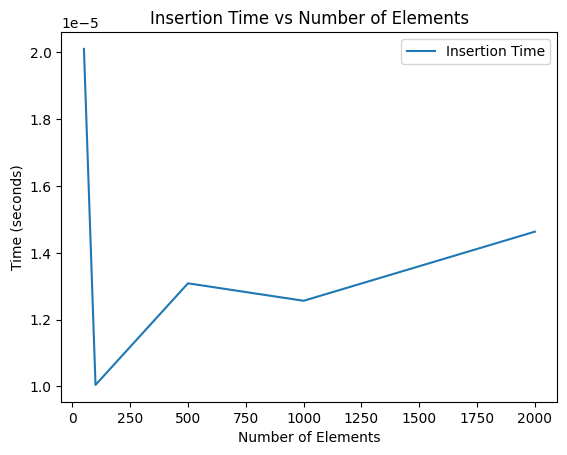

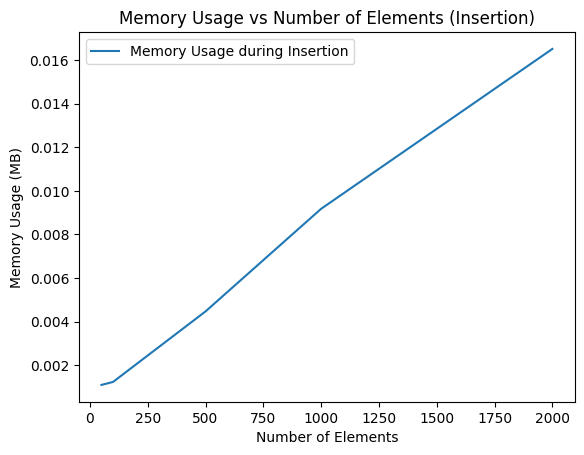

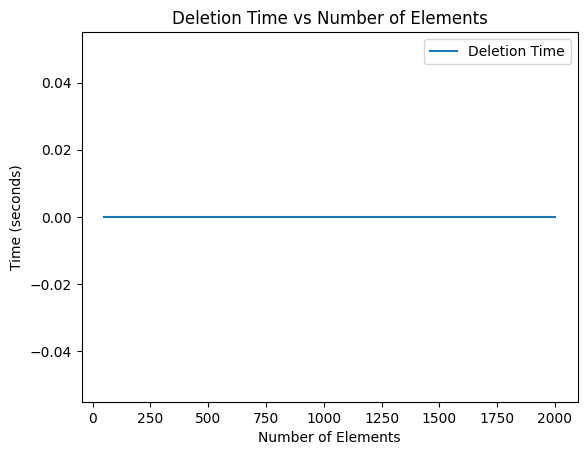

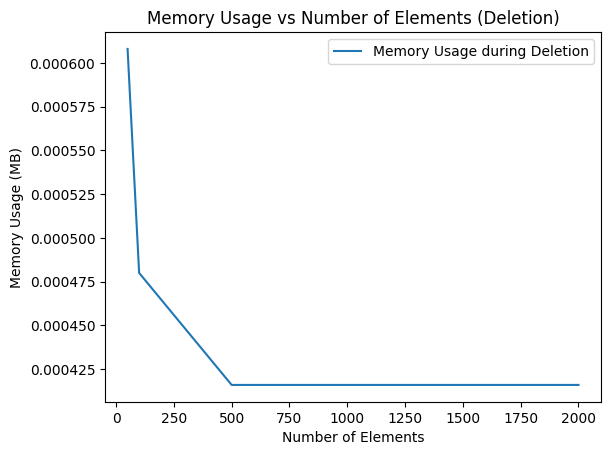

In [8]:
import time
import tracemalloc
import matplotlib.pyplot as plt

class TreeNode:
    def __init__(self, is_leaf=True):
        self.keys = []
        self.children = []
        self.is_leaf = is_leaf

class BTree:
    def __init__(self, t):
        self.root = TreeNode()
        self.t = t

    def insert(self, key):
        root = self.root
        if len(root.keys) == (2 * self.t) - 1:
            new_root = TreeNode(is_leaf=False)
            new_root.children.append(root)
            self._split_child(new_root, 0)
            self.root = new_root
            self._insert_non_full(new_root, key)
        else:
            self._insert_non_full(root, key)

    def _insert_non_full(self, node, key):
        i = len(node.keys) - 1
        if node.is_leaf:
            node.keys.append(None)
            while i >= 0 and key < node.keys[i]:
                node.keys[i + 1] = node.keys[i]
                i -= 1
            node.keys[i + 1] = key
        else:
            while i >= 0 and key < node.keys[i]:
                i -= 1
            i += 1
            if len(node.children[i].keys) == (2 * self.t) - 1:
                self._split_child(node, i)
                if key > node.keys[i]:
                    i += 1
            self._insert_non_full(node.children[i], key)

    def _split_child(self, parent, index):
        t = self.t
        child = parent.children[index]
        new_child = TreeNode(is_leaf=child.is_leaf)
        parent.children.insert(index + 1, new_child)
        parent.keys.insert(index, child.keys[t - 1])
        new_child.keys = child.keys[t: (2 * t) - 1]
        child.keys = child.keys[:t - 1]
        if not child.is_leaf:
            new_child.children = child.children[t:]
            child.children = child.children[:t]

    def delete(self, key):
        self._delete_from_node(self.root, key)
        if len(self.root.keys) == 0:
            if not self.root.is_leaf:
                self.root = self.root.children[0]
            else:
                self.root = None

    def _delete_from_node(self, node, key):
        t = self.t
        i = 0
        while i < len(node.keys) and key > node.keys[i]:
            i += 1
        if i < len(node.keys) and key == node.keys[i]:
            if node.is_leaf:
                node.keys.pop(i)
            else:
                self._delete_internal_node(node, key, i)
        elif node.is_leaf:
            return
        else:
            if len(node.children[i].keys) < t:
                self._fill(node, i)
            if i > len(node.keys):
                self._delete_from_node(node.children[i - 1], key)
            else:
                self._delete_from_node(node.children[i], key)

    def _delete_internal_node(self, node, key, index):
        t = self.t
        if len(node.children[index].keys) >= t:
            pred_key = self._get_predecessor(node, index)
            node.keys[index] = pred_key
            self._delete_from_node(node.children[index], pred_key)
        elif len(node.children[index + 1].keys) >= t:
            succ_key = self._get_successor(node, index)
            node.keys[index] = succ_key
            self._delete_from_node(node.children[index + 1], succ_key)
        else:
            self._merge(node, index)
            self._delete_from_node(node.children[index], key)

    def _get_predecessor(self, node, index):
        current = node.children[index]
        while not current.is_leaf:
            current = current.children[-1]
        return current.keys[-1]

    def _get_successor(self, node, index):
        current = node.children[index + 1]
        while not current.is_leaf:
            current = current.children[0]
        return current.keys[0]

    def _fill(self, node, index):
        t = self.t
        if index != 0 and len(node.children[index - 1].keys) >= t:
            self._borrow_from_prev(node, index)
        elif index != len(node.keys) and len(node.children[index + 1].keys) >= t:
            self._borrow_from_next(node, index)
        else:
            if index != len(node.keys):
                self._merge(node, index)
            else:
                self._merge(node, index - 1)

    def _borrow_from_prev(self, node, index):
        child = node.children[index]
        sibling = node.children[index - 1]

        for i in range(len(child.keys) - 1, -1, -1):
            child.keys.insert(0, child.keys.pop())
        if not child.is_leaf:
            for i in range(len(child.children) - 1, -1, -1):
                child.children.insert(0, child.children.pop())
        child.keys[0] = node.keys[index - 1]
        if not child.is_leaf:
            child.children[0] = sibling.children.pop()

        node.keys[index - 1] = sibling.keys.pop()

    def _borrow_from_next(self, node, index):
        child = node.children[index]
        sibling = node.children[index + 1]

        child.keys.append(node.keys[index])
        if not child.is_leaf:
            child.children.append(sibling.children.pop(0))

        node.keys[index] = sibling.keys.pop(0)

    def _merge(self, node, index):
        child = node.children[index]
        sibling = node.children[index + 1]

        child.keys.append(node.keys.pop(index))
        for key in sibling.keys:
            child.keys.append(key)
        if not child.is_leaf:
            for child_node in sibling.children:
                child.children.append(child_node)
        node.children.pop(index + 1)

# Функція для вимірювання часу і пам'яті
def measure_performance(tree, elements, operation):
    times = []
    memory_usage = []
    for element in elements:
        start_time = time.time()
        tracemalloc.start()
        
        if operation == "insert":
            tree.insert(element)
        elif operation == "delete":
            tree.delete(element)
        
        end_time = time.time()
        times.append(end_time - start_time)
        
        current, peak = tracemalloc.get_traced_memory()
        memory_usage.append(peak / 10**6)  # Convert bytes to megabytes
        tracemalloc.stop()
    return times, memory_usage

# Приклад використання:
sizes = [50, 100, 500, 1000, 2000]
insertion_times_all = []
memory_usage_insert_all = []
deletion_times_all = []
memory_usage_delete_all = []

for size in sizes:
    b_tree = BTree(2)
    elements = list(range(1, size + 1))
    
    # Вставка елементів
    insertion_times, memory_usage_insert = measure_performance(b_tree, elements, "insert")
    insertion_times_all.append(sum(insertion_times) / size)  # Середній час вставки
    memory_usage_insert_all.append(max(memory_usage_insert))  # Максимальне використання пам'яті під час вставки
    
    # Видалення останнього елементу
    deletion_times, memory_usage_delete = measure_performance(b_tree, [elements[-1]], "delete")
    deletion_times_all.append(sum(deletion_times))  # Час видалення
    memory_usage_delete_all.append(max(memory_usage_delete))  # Максимальне використання пам'яті під час видалення

# Побудова графіків для вставки
plt.plot(sizes, insertion_times_all, label='Insertion Time')
plt.xlabel('Number of Elements')
plt.ylabel('Time (seconds)')
plt.title('Insertion Time vs Number of Elements')
plt.legend()
plt.show()

plt.plot(sizes, memory_usage_insert_all, label='Memory Usage during Insertion')
plt.xlabel('Number of Elements')
plt.ylabel('Memory Usage (MB)')
plt.title('Memory Usage vs Number of Elements (Insertion)')
plt.legend()
plt.show()

# Побудова графіків для видалення
plt.plot(sizes, deletion_times_all, label='Deletion Time')
plt.xlabel('Number of Elements')
plt.ylabel('Time (seconds)')
plt.title('Deletion Time vs Number of Elements')
plt.legend()
plt.show()

plt.plot(sizes, memory_usage_delete_all, label='Memory Usage during Deletion')
plt.xlabel('Number of Elements')
plt.ylabel('Memory Usage (MB)')
plt.title('Memory Usage vs Number of Elements (Deletion)')
plt.legend()
plt.show()
